In [1]:
# imports
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import transforms

In [8]:
# use this cell to select which features u want to use
# e.g. xy[:, :-1] to select all features
def extract_data(xy_filepath):
    xy = np.genfromtxt(xy_filepath, delimiter=',')
    return xy[:, :-1].astype(np.float), xy[:, -1].astype(int)       # all features
#     return xy[:, [1, 3, 5, 7]].astype(np.float), xy[:, -1].astype(int)      # roundsWon, map_roundsWon, avg adr, max adr

In [9]:
class Dataset(Dataset):
    def __init__(self, X, y, transformations=None):
        self.len = len(X)
        self.x_data = torch.from_numpy(X).float()
        self.y_data = torch.from_numpy(y).float()
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [10]:
# load data into global variable space
# split between test and train sets
FRAC_TRAIN = 0.8
X, y = extract_data('./Xy.txt')
num_train = int(FRAC_TRAIN * len(X))
indices = np.random.permutation(len(X))
train_indices, test_indices = indices[:num_train], indices[num_train:]
X_train = X[train_indices, :]
y_train = y[train_indices]
X_test = X[test_indices, :]
y_test = y[test_indices]

train_dataset = Dataset(X_train, y_train)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=128,
                          shuffle=True)
test_dataset = Dataset(X_test, y_test)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=128,
                         shuffle=True)

In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(8, 15)
        self.fc2 = nn.Linear(15, 15)
        self.fc3 = nn.Linear(15, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
#         x = torch.sigmoid(self.fc4(x))
        return x

In [12]:
def plot_latest_experiment():
    epoch_number = np.arange(0, max_epochs, 1)

    # Plot the loss over epoch
    plt.figure()
    plt.plot(epoch_number, train_losses)
    plt.title('loss over epochs')
    plt.xlabel('Number of Epoch')
    plt.ylabel('Loss')
    plt.show()

    # Plot the training accuracy over epoch
    plt.figure()
    plt.plot(epoch_number, train_accuracies)
    plt.title('training accuracy over epochs')
    plt.xlabel('Number of Epoch')
    plt.ylabel('accuracy')
    plt.show()

    # Plot the test accuracy over epoch
    plt.figure()
    plt.plot(epoch_number, test_accuracies)
    plt.title('test accuracy over epochs')
    plt.xlabel('Number of Epoch')
    plt.ylabel('accuracy')
    plt.show()

In [13]:
def run_experiment(neural_network, train_loader, test_loader, loss_function, optimizer):
    """
    this function is copy-pasted from hw3. look there for more info
    Returns tuple: (testing accuracy, training accuracy, training loss), e.g. (0.76, 0.24, 0.56)
    """
    # first pass: train the model
    for i, data in enumerate(train_loader, 0):
        # Get inputs and labels from data loader 
        inputs, labels = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the gradients
        optimizer.zero_grad()

        # predict, forward, backwards, optimize (update weights)
        y_pred = net(inputs)
        loss = loss_function(y_pred, labels.view(-1, 1))
        loss.backward()
        optimizer.step()

    # second pass: calculate stats
    train_total_correct = 0
    train_total_loss = 0
    train_total_instances = 0
    for i, data in enumerate(train_loader, 0):
        # Get inputs and labels from data loader 
        inputs, labels = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        num_instances = len(labels)
        
        # predict
        y_pred = net(inputs)
        loss = loss_function(y_pred, labels.view(-1, 1))
        train_total_loss += num_instances * loss.item()
        
        # calculate the training accuracy
        pred_np = np.round(y_pred.data.cpu().numpy().reshape(len(labels), 1)).astype(int)
        label_np = labels.data.cpu().numpy().reshape(len(labels), 1)
        
        for j in range(pred_np.shape[0]):
            if pred_np[j,:] == label_np[j,:]:
                train_total_correct += 1
        train_total_instances += num_instances
        
    train_accuracy = float(train_total_correct) / float(train_total_instances)
    train_loss = float(train_total_loss) / float(train_total_instances)
    
    # pass for test data: calculate stats
    test_total_correct = 0
    test_total_instances = 0
    for i, data in enumerate(test_loader, 0):
        # Get inputs and labels from data loader 
        inputs, labels = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        num_instances = len(labels)
        
        # predict
        y_pred = net(inputs)
        loss = loss_function(y_pred, labels.view(-1, 1))
        
        # calculate the test accuracy
        pred_np = np.round(y_pred.data.cpu().numpy().reshape(len(labels), 1)).astype(int)
        label_np = labels.data.cpu().numpy().reshape(len(labels), 1)

        for j in range(pred_np.shape[0]):
            if pred_np[j,:] == label_np[j,:]:
                test_total_correct += 1
        test_total_instances += num_instances
        
    test_accuracy = float(test_total_correct) / float(test_total_instances)

    return (test_accuracy, train_accuracy, train_loss)

epoch: 0
epoch: 10
epoch: 20
epoch: 30
epoch: 40
epoch: 50
epoch: 60
epoch: 70
final train accuracy: 0.598835907768077
final train loss: 0.6588754629485688
final test accuracy: 0.5989434097421203


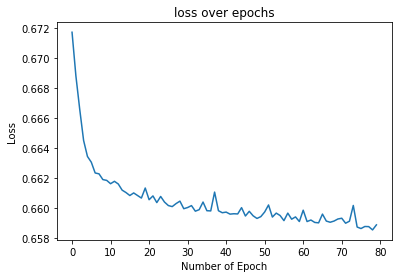

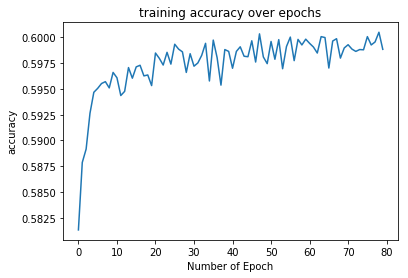

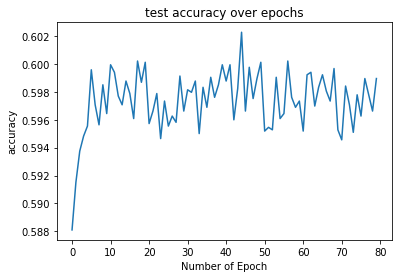

In [14]:
net = NeuralNetwork()
net.cuda()

max_epochs = 80
train_losses = np.zeros((max_epochs))
train_accuracies = np.zeros((max_epochs))
test_accuracies = np.zeros((max_epochs))

criterion = nn.BCELoss()
# optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)
for epoch in range(max_epochs):
    if epoch % 10 == 0:
        print("epoch:", epoch)
    test_accuracy, train_accuracy, train_loss = run_experiment(
        net,
        train_loader,
        test_loader,
        criterion,
        optimizer
    )
    train_losses[epoch] = train_loss
    train_accuracies[epoch] = train_accuracy
    test_accuracies[epoch] = test_accuracy

print("final train accuracy:", train_accuracies[max_epochs - 1])
print("final train loss:", train_losses[max_epochs - 1])
print("final test accuracy:", test_accuracies[max_epochs - 1])
plot_latest_experiment()